## N차 과제 - Time Series Analysis_주가예측

- 주제: 시계열 모델을 주가 데이터에 대한 시계열 예측 및 분석
- 데이터: 주식 데이터(크롤링 or 라이브러리로 데이터 불러오기)
- 사용 라이브러리: yfinance, datareader, statsmodels, matplotlib etc.

In [5]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose


### 1. EDA 및 전처리

1.1 분석을 위해 사용할 특정 주식(1개)의 데이터를 불러오거나 크롤링하여 가져오세요(**최소 3년 이상의 데이터 추출 권고**).

In [6]:
df = yf.download('NVDA', start = '2019-10-04', end = '2024-08-04')
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-04,4.535000,4.578750,4.469500,4.549250,4.527229,265524000
2019-10-07,4.614500,4.708500,4.605750,4.608250,4.585945,480984000
2019-10-08,4.516000,4.516000,4.412500,4.430750,4.409303,444436000
2019-10-09,4.508000,4.567500,4.479000,4.517750,4.495883,292412000
2019-10-10,4.515500,4.627000,4.510250,4.575750,4.553602,309124000
...,...,...,...,...,...,...
2024-07-29,113.690002,116.279999,111.300003,111.589996,111.580452,248152100
2024-07-30,111.519997,111.989998,102.540001,103.730003,103.721130,486833300
2024-07-31,112.900002,118.339996,110.879997,117.019997,117.009987,473174200


1.2 결측치가 있는지 확인하고 있다면 제거해주세요.

In [9]:
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

1.3 일자를 인덱스로 설정하고 시간 순서대로 정렬하세요.

In [12]:
df = df.sort_index()
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-10-04,4.535000,4.578750,4.469500,4.549250,4.527229,265524000
2019-10-07,4.614500,4.708500,4.605750,4.608250,4.585945,480984000
2019-10-08,4.516000,4.516000,4.412500,4.430750,4.409303,444436000
2019-10-09,4.508000,4.567500,4.479000,4.517750,4.495883,292412000
2019-10-10,4.515500,4.627000,4.510250,4.575750,4.553602,309124000
...,...,...,...,...,...,...
2024-07-29,113.690002,116.279999,111.300003,111.589996,111.580452,248152100
2024-07-30,111.519997,111.989998,102.540001,103.730003,103.721130,486833300
2024-07-31,112.900002,118.339996,110.879997,117.019997,117.009987,473174200


1.4 수정종가(adj close)와 거래량(volume)을 시각화하세요.

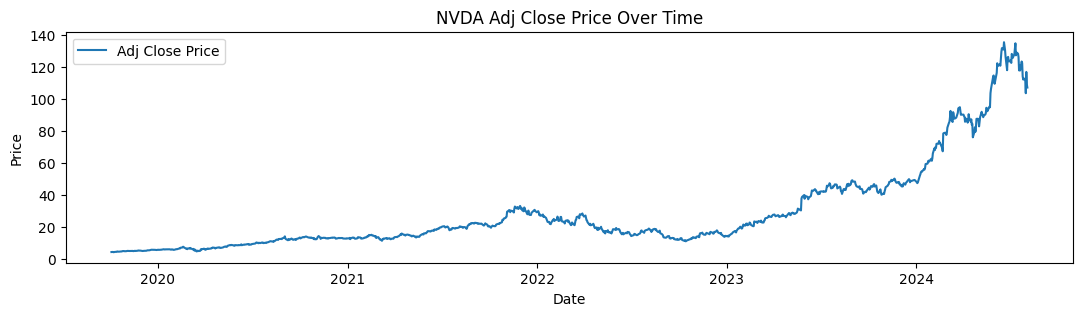

In [15]:
plt.figure(figsize=(13, 3))
plt.plot(df.index, df['Adj Close'], label='Adj Close Price')
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('NVDA Adj Close Price Over Time')
plt.legend()
plt.show()

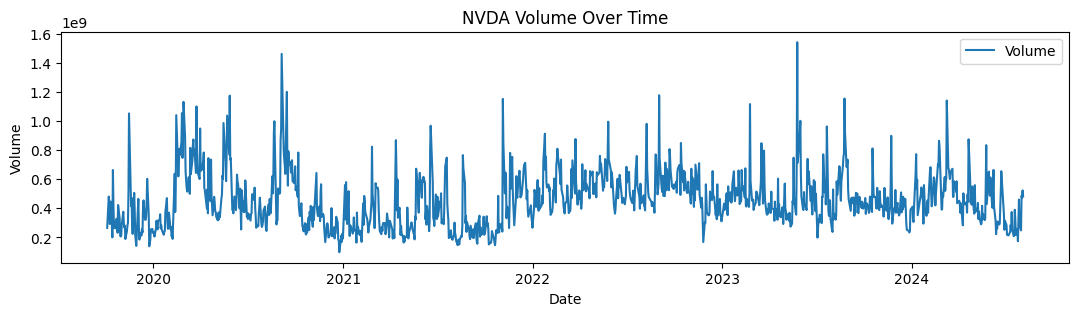

In [17]:
plt.figure(figsize=(13, 3))
plt.plot(df.index, df['Volume'], label='Volume')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.title('NVDA Volume Over Time')
plt.legend()
plt.show()

1.5 위 시각화 과정을 통해 알 수 있는 내용에 대해 작성하세요.

In [ ]:
#그래프가 우상향한다

### 2. 추세 및 정상성 검정

2.1 시계열 데이터의 정상성을 검증하도록 하겠습니다. 시계열 데이터 말하는 정상성(stationarity)이 무엇인지 왜 해야 하며 비정상성의 해결 방법에는 무엇이 있는지 작성하세요.

과거 관찰값을 바탕으로 미래를 예측하기 위해서는 수집된 관측값이 안정적으로 유지되고 있는 상태인지, 또는 계속해서 변동하는 상태인지를 확인해야 합니다. 이 때, 시계열의 안정적 수준이 바로 “정상성(Stationarity)”이며, 정상이란 변하지 않고 일정한 상태인 트랜드가 없다 (오르거나 줄어들지 않는다), 분산이 일정하다, 자기상관이 일정하다.
해결 방법은 차분, 로그 변환, 로그 차분이 있습니다

2.2 먼저 ADF Test를 수행하겠습니다. statsmodels의 adfuller 라이브러리를 import 한 후 수정 종가에 대한 검정을 수행하고 결과를 출력하세요(p-value 포함).

ADF Test란? - https://hongl.tistory.com/98

In [19]:
result = adfuller(df['Adj Close'])

print(f'ADF statistics : {result[0]}')
print(f'p-value {result[1]}')
print('critical values: ')
for key, value in result[4].items():
    print(f"\t{key} {value}")

ADF statistics : -0.019302512878315616
p-value 0.9569063722290816
critical values: 
	1% -3.43584323237365
	5% -2.863965714307509
	10% -2.5680614958661483


2.3 ADF Test 결과를 해석하세요.

1. ADF 통계량: -0.0193
- ADF 통계량은 주어진 시계열 데이터에 단위근(unit root)이 있는지를 테스트하는 지표입니다.
- 값이 음수일수록, 시계열이 정상성을 가질 가능성이 높아집니다. 하지만 이 경우 통계량이 -0.0193으로 매우 낮습니다. 이는 시계열이 비정상적일 가능성을 시사합니다.

2. p-value: 0.9569
- p-value는 귀무가설이 참일 확률을 나타냅니다. ADF 테스트의 귀무가설은 **"단위근이 존재하며, 시계열이 비정상적이다"**입니다.
- p-value가 0.05보다 크면 귀무가설을 기각할 수 없습니다. 여기서 p-value가 0.9569로 매우 높으므로, 귀무가설을 기각할 수 없으며 시계열이 비정상적이라는 결론을 내릴 수 있습니다.

3. 임계값 (Critical values):
- 1% 수준: -3.4358
- 5% 수준: -2.8640
- 10% 수준: -2.5681

이 임계값들은 각각의 유의 수준에서 ADF 통계량이 떨어져야 할 최소값을 나타냅니다. ADF 통계량(-0.0193)은 이 임계값들보다 훨씬 큽니다. 따라서 유의 수준 1%, 5%, 10% 모두에서 귀무가설을 기각할 수 없습니다.

결론:
- p-value가 높고, ADF 통계량이 임계값보다 큽니다. 따라서, 이 시계열 데이터는 단위근을 가지고 있으며, 비정상적이라고 결론지을 수 있습니다.

2.4 ACF 그래프와 PACF 그래프를 그려보도록 하겠습니다. 먼저 ACF와 PACF 각각이 어떻게 다른지 설명하세요.

시차에 따른 일련의 자기상관을 자기상관함수(ACF)라고 합니다. ACF는 시차에 따른 관측값 간의 연관 정도를 보여주며, 시차가 커질수록 ACF는 점차 0에 가까워집니다.
(시차가 멀어질수록 당연히 상관관계는 떨어집니다. seasonal한 데이터의 겨우 특정주기에 따라 다시 튀어오르는 구간이 있습니다.)
ACF는 시계열의 정상성을 평가할 때 유용합니다. 정상 시계열의 경우 ACF는 상대적으로 빨리 0(상관관계가 0)으로 접근합니다. 비정상 시계열의 경우 ACF는 천천히 감소하며 종종 큰 양의 값을 가집니다.
시차에 따른 일련의 편자기 상관을 편자기 상관함수(PACF)라고 합니다. 시차가 다른 두 시계열 데이터 간의 순수한 상호 연관성을 나타냅니다. 즉, t시점과 t-1의 연관성, 그리고 t와 t-2의 연관성입니다 (이때 t-1와의 연관성은 제외, 순수하게 특정 시점간의 연관성(correlation)만 생각하고 사이에 있는 시점들의 연관성은 제외)

2.5 statsmodels의 plot_acf, plot_pacf 라이브러리를 import하고 Adj close값에 대한 ACF, PACF 그래프를 출력하세요.

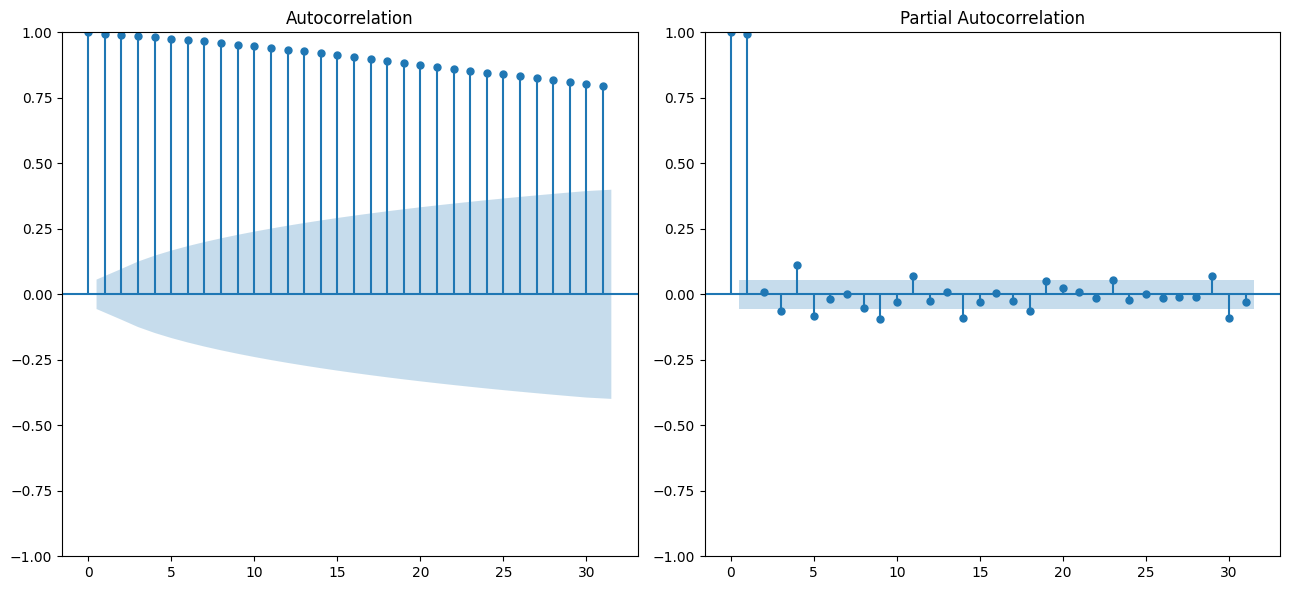

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(13, 6))

plot_acf(df['Adj Close'], ax=axes[0], title='Autocorrelation')
plot_pacf(df['Adj Close'], ax=axes[1], title='Partial Autocorrelation')

plt.tight_layout()
plt.show()

2.6 결과를 해석하세요.

1. ACF(왼쪽 그래프) 분석:
ACF 그래프에서 보면, **모든 시차(lag)**에서 자기상관 계수가 매우 높고, 서서히 감소하는 모습을 보입니다.
이는 시계열 데이터가 강한 자기상관을 가지고 있으며, 비정상적(non-stationary)일 가능성이 큽니다.
특히, 1차 차분이 필요할 수 있음을 시사합니다.
단위근이 존재하는 비정상적인 시계열의 경우, ACF 그래프가 이런 식으로 서서히 감소하는 경향이 있습니다.
2. PACF(오른쪽 그래프) 분석:
PACF 그래프는 **첫 번째 시차(lag 1)**에서 매우 강한 양의 상관이 나타나고, 그 이후 시차에서는 거의 상관이 없는 형태를 보입니다.
이는 AR(1) 모델이 적합할 가능성을 시사합니다. 즉, 과거 1시차 이전의 데이터는 현재 시점에 큰 영향을 미치지 않는다는 의미입니다.

2.7 마지막으로 계절성이 있는지 여부를 확인하겠습니다. statsmodels의 seasonal_decompose 라이브러리를 import하고 plot을 출력하세요.

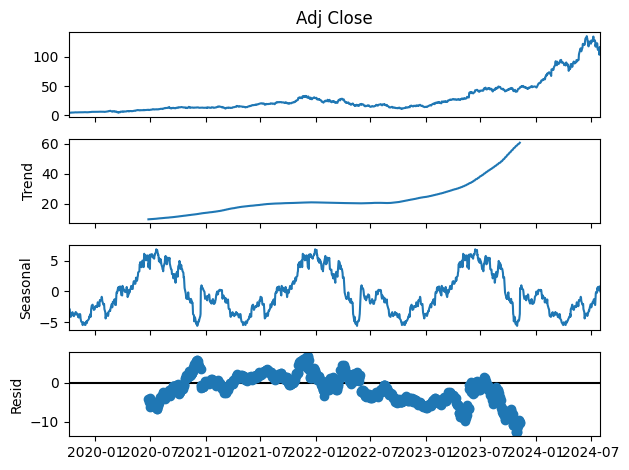

In [30]:
season = seasonal_decompose(df['Adj Close'], model='additive', period=365) #연간패턴을 보기 위해 period를 365로 설정
season.plot()

plt.show()

2.8 위 결과를 해석하세요.

추세는 장기적으로 상승하고 있으며, 데이터가 비정상적이라는 점을 보여줍니다.
계절성 요소는 강한 주기적 패턴을 보이므로, 계절성을 고려한 모델이 적합할 수 있습니다.
잔차가 완전히 무작위적이지는 않지만, 추세와 계절성을 제거한 후에도 여전히 일정 부분 설명되지 않는 변동이 존재합니다. 
이는 추가적인 분석이 필요할 수 있음을 시사합니다.

2.9 위에서 진행한 검정 과정 및 시각화 결과를 종합해봤을 때 현 데이터는 비정상성임을 알 수 있습니다. 따라서 차분을 통해 이를 해결하도록 하겠습니다. 먼저 차분이 어떤 것인지에 대해 설명하세요.

차분(differencing): 주어진 시계열의 변화분을 구하는 과정.

2.10 1차 차분을 진행하도록 하겠습니다. diff() 함수를 활용해 1차 차분을 진행한 후 ADF Test를 수행하여 정상성 여부를 확인하세요.

In [33]:
df['Adj Close Diff'] = df['Adj Close'].diff()
result = adfuller(df['Adj Close Diff'].dropna())
statistic = result[0]
p_value = result[1]
critical_values = result[4]

print(f"ADF Statistic: {statistic}")
print(f"p-value: {p_value}")
print("Critical Values:")
for key, value in critical_values.items():
    print(f"   {key}: {value}")

ADF Statistic: -5.419916718392152
p-value: 3.0757658659624615e-06
Critical Values:
   1%: -3.43584323237365
   5%: -2.863965714307509
   10%: -2.5680614958661483


2.11 추가로 위에서 그려보았던 plot들을 다시 그려보면서 비교를 통해 정상성 여부를 확인해보도록 하겠습니다. ACF PACF plot, 계절성 분해 plot을 그려보세요.

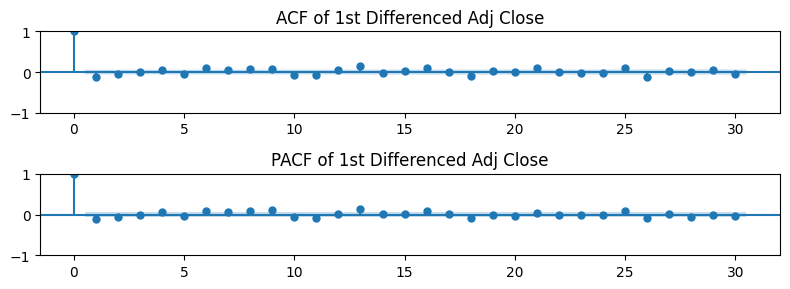

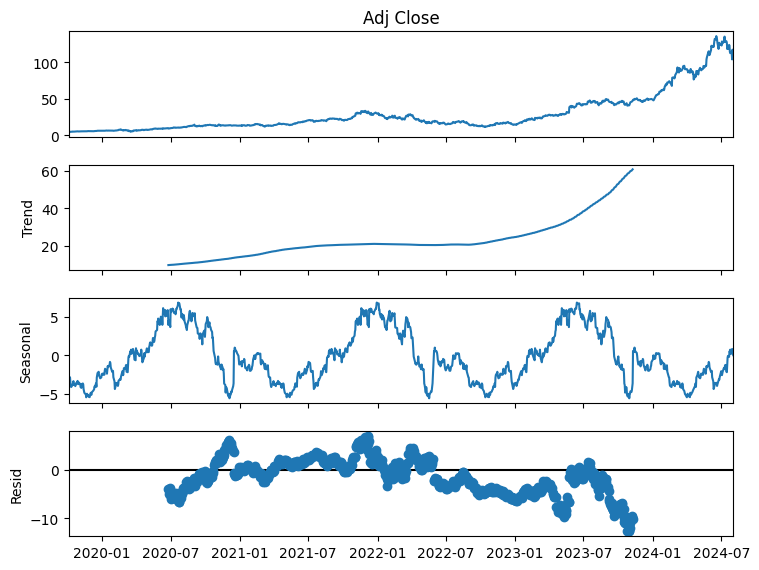

In [55]:
# ACF 및 PACF 플롯
fig, axes = plt.subplots(2, 1, figsize=(8, 3))
plot_acf(df['Adj Close Diff'].dropna(), ax=axes[0], lags=30)
axes[0].set_title('ACF of 1st Differenced Adj Close')
plot_pacf(df['Adj Close Diff'].dropna(), ax=axes[1], lags=30)
axes[1].set_title('PACF of 1st Differenced Adj Close')
plt.tight_layout()
plt.show()

# 계절성 분해
decomposition = seasonal_decompose(df['Adj Close'], model='additive', period=365)
decomposition.observed.index = df.index
fig = decomposition.plot()
fig.set_size_inches(8, 6)
plt.show()

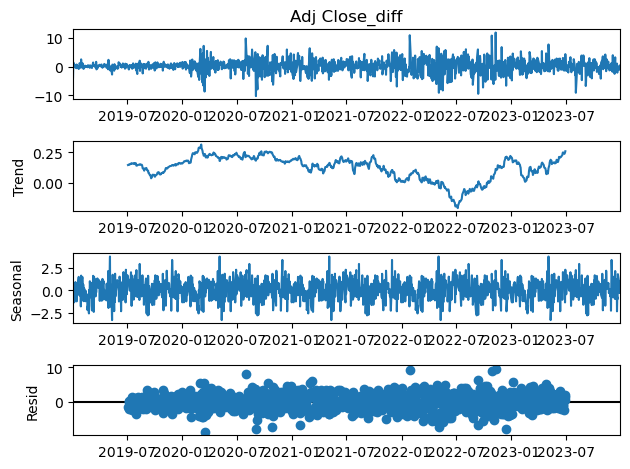

### 3. 예측

3.1 데이터의 정상성을 확인했으니 본격적으로 예측 및 분석을 진행해보도록 하겠습니다.

아래 코드는 예시이므로 예시에서 사용된 모델이 아닌 다른 모델(ex. ARIMAX, ARCH/GARCH, LSTM, Transformer, DLinear etc.)를 사용하고 애플이 아닌 다른 주식을 사용해 예측 및 분석을 진행해주세요(**위에서 진행한 과정 역시 모두 예시이므로 새로운 주식에 대한 전처리 및 정상성 검정을 새로 진행해야 함**).

In [12]:
from statsmodels.tsa.arima.model import ARIMA

In [23]:
data['Adj Close_diff']

Date
2019-01-02         NaN
2019-01-03   -3.760181
2019-01-04    1.450996
2019-01-07   -0.078880
2019-01-08    0.674103
                ...   
2023-12-22   -1.075882
2023-12-26   -0.547943
2023-12-27    0.099625
2023-12-28    0.428375
2023-12-29   -1.046036
Name: Adj Close_diff, Length: 1258, dtype: float64

In [24]:
model = ARIMA(data['Adj Close_diff'], order=(3, 0, 0))  #위에서 차분을 미리 했으므로 차분 값은 0으로 설정
model_fit = model.fit()


model_fit.summary()

C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:         Adj Close_diff   No. Observations:                 1258
Model:                 ARIMA(3, 0, 0)   Log Likelihood               -2858.574
Date:                Tue, 27 Aug 2024   AIC                           5727.148
Time:                        23:58:51   BIC                           5752.834
Sample:                             0   HQIC                          5736.801
                               - 1258                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1227      0.062      1.969      0.049       0.001       0.245
ar.L1         -0.0434      0.022     -1.986      0.047      -0.086      -0.001
ar.L2         -0.0264      0.023     -1.162      0.245      -0.071       0.018
ar.L3         -0.0158      0.024     -0.658      0.511      -0.063       0.031
sigma2         5.5310      0.149     37.232      0.000       5.240       5.822
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               349.98
Prob(Q):                              1.00   Prob(JB):                         0.00
Heteroskedasticity (H):               3.12   Skew:                            -0.12
Prob(H) (two-sided):                  0.00   Kurtosis:                         5.57
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

C:\Users\bumbk\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


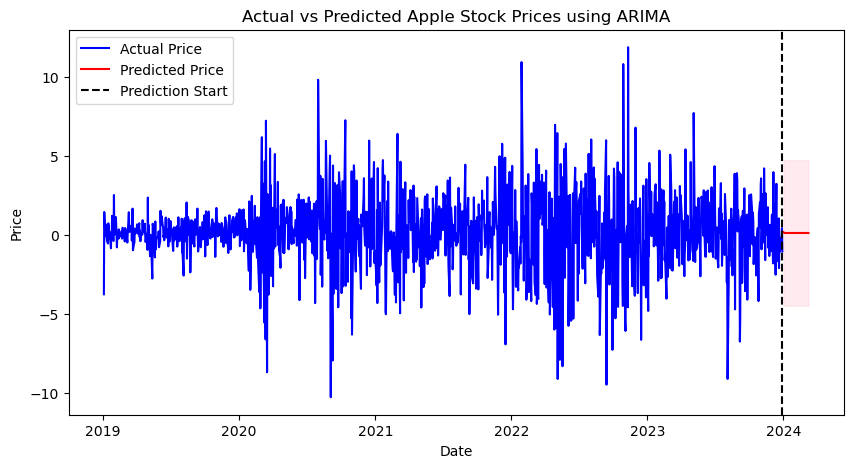

In [26]:
#예측 수행(50일, 200일해도 달라지지 않았음 ㅠ)
forecast_result = model_fit.get_forecast(steps=50)
forecast = forecast_result.predicted_mean
conf_int = forecast_result.conf_int()

#예측 결과 시각화
plt.figure(figsize=(10, 5))
plt.plot(df.index, data['Adj Close_diff'], label='Actual Price', color='blue')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price', color='red')
plt.fill_between(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.axvline(x=data.index[-1], color='black', linestyle='--', label='Prediction Start')
plt.title('Actual vs Predicted Apple Stock Prices using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

In [28]:
#실제 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-03-01')
actual_last_50 = actual_data_last_50[['Close']]


[*********************100%%**********************]  1 of 1 completed


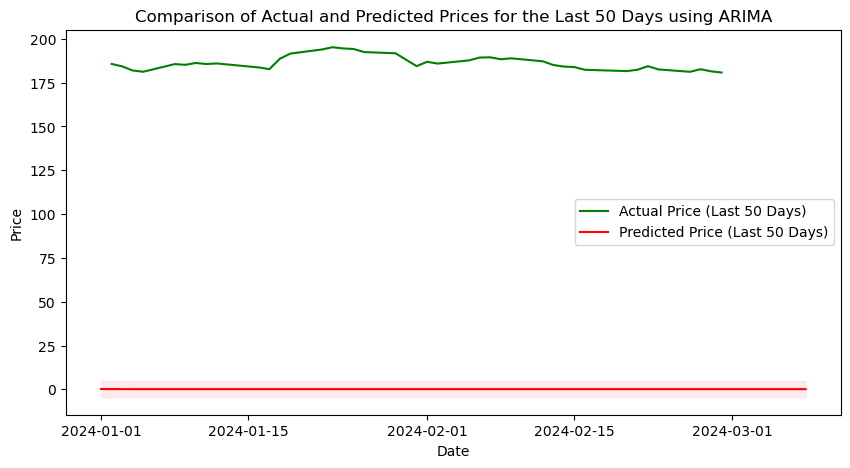

In [29]:
#실제 데이터와 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(actual_last_50.index, actual_last_50['Close'], label='Actual Price (Last 50 Days)', color='green')
plt.plot(pd.date_range(start=data.index[-1], periods=51, freq='B')[1:], forecast, label='Predicted Price (Last 50 Days)', color='red')
plt.fill_between(pd.date_range(start=df.index[-1], periods=51, freq='B')[1:], conf_int.iloc[:, 0], conf_int.iloc[:, 1], color='pink', alpha=0.3)
plt.title('Comparison of Actual and Predicted Prices for the Last 50 Days using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

ARIMA에서는 성능이 왠지는 모르겠으나 잘 안 나와서 이정도만 하고 넘어가겠습니다. 밑에서 진행할 Prophet 모형의 경우 예측이 제대로 진행되어 추세를 예측하고자 단기적 예측이라 할 수 있는 50일이 아닌 향후 200일을 예측하였습니다.

### Prophet

Prophet 모델이란?
https://wikidocs.net/233162

In [30]:
from prophet import Prophet

In [31]:
###Prophet의 경우 ARIMA와 검정 및 전처리 과정이 약간 달라 새로 진행하였으며 보다 정확한 추세 예측을 위해 200일까지 예측하였습니다.###


ticker = 'AAPL'
data = yf.download(ticker, start='2019-01-01', end='2024-01-01')

df = data.reset_index()[['Date', 'Close']]
df.columns = ['ds', 'y']  #Prophet에서는 날짜 컬럼을 'ds', 값 컬럼을 'y'로 설정해야 함

[*********************100%%**********************]  1 of 1 completed


In [33]:
#모델 설정(파라미터는 따로 설정하지 않고 진행했으나 보다 정확한 예측을 위해 수정하는 것도 좋음)
model = Prophet()
model.fit(df)

00:06:19 - cmdstanpy - INFO - Chain [1] start processing
00:06:19 - cmdstanpy - INFO - Chain [1] done processing


In [34]:
#200일간의 예측 진행
future = model.make_future_dataframe(periods=200)
forecast = model.predict(future)

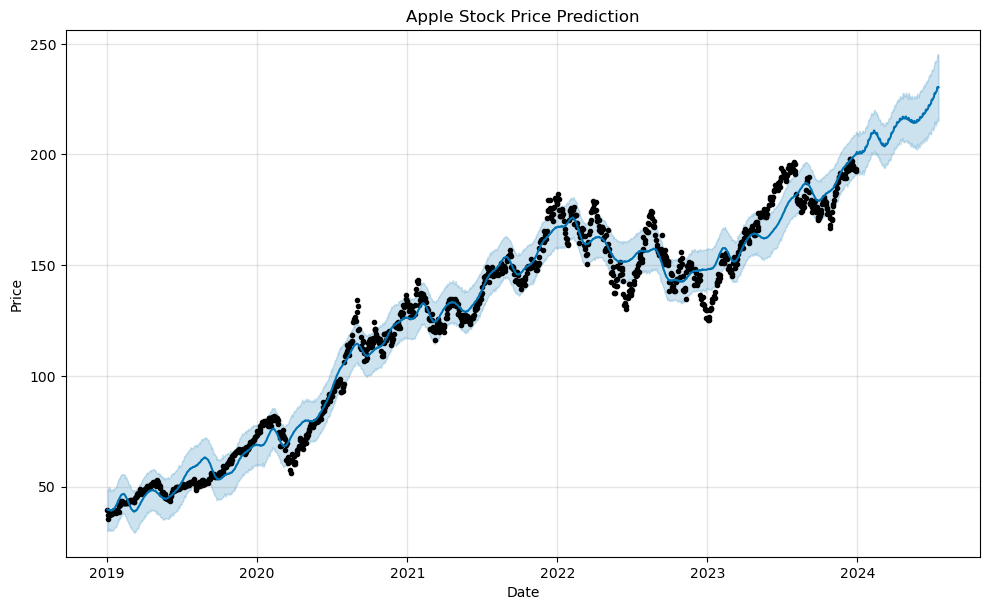

In [35]:
# 예측 결과 시각화
fig1 = model.plot(forecast)
plt.title('Apple Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.show()

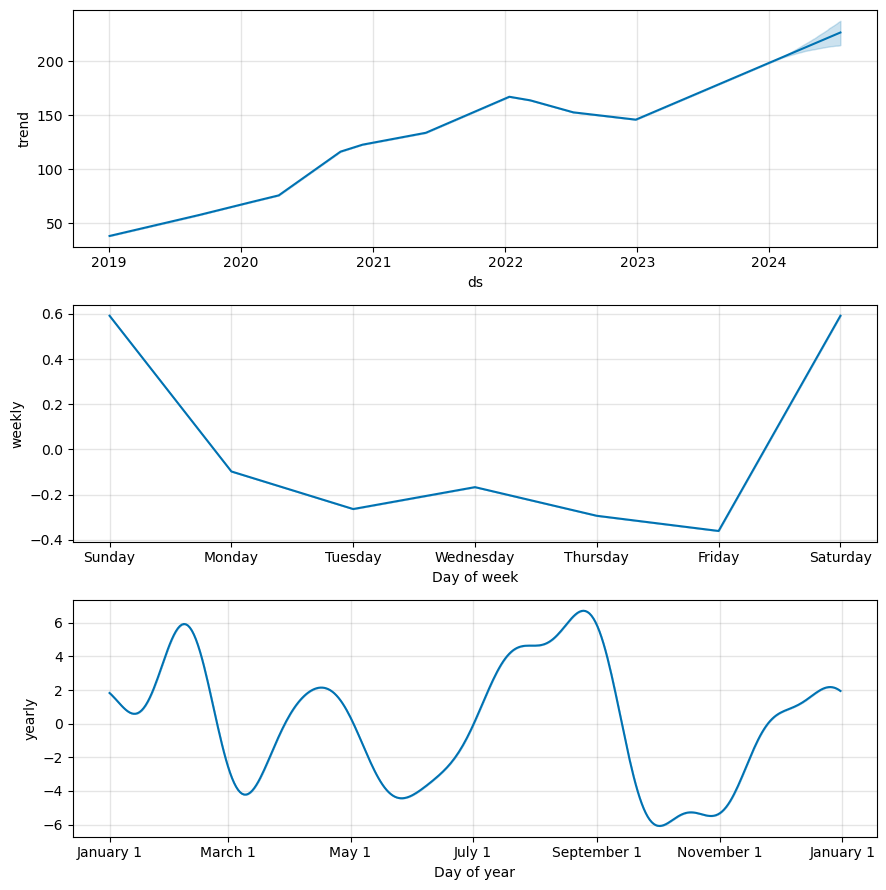

In [36]:
#트렌드 및 주기성 시각화
fig2 = model.plot_components(forecast)
plt.show()

In [37]:
#마지막 200일의 실제 주가 데이터 가져오기
actual_data_last_50 = yf.download(ticker, start='2024-01-01', end='2024-08-01')
actual_last_50 = actual_data_last_50.reset_index()[['Date', 'Close']]
actual_last_50.columns = ['ds', 'y']

[*********************100%%**********************]  1 of 1 completed


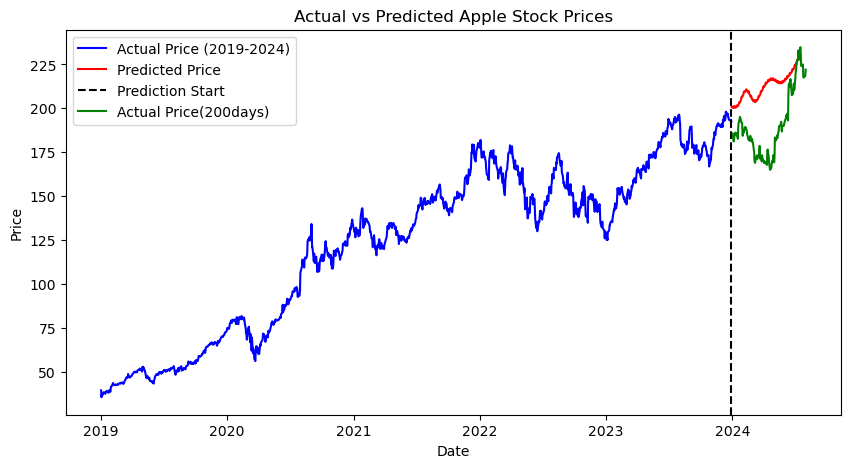

In [41]:
#실제 값과 비교 시각화
plt.figure(figsize=(10, 5))
plt.plot(df['ds'], df['y'], label='Actual Price (2019-2024)', color='blue')

plt.plot(forecast['ds'][len(df):], forecast['yhat'][len(df):], label='Predicted Price', color='red') ##전체 예측값 중 200일 이후 것만 사용
plt.axvline(x=df['ds'].iloc[-1], color='black', linestyle='--', label='Prediction Start')
plt.plot(actual_last_50['ds'], actual_last_50['y'], label='Actual Price(200days)', color='green')
plt.title('Actual vs Predicted Apple Stock Prices')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


예시에서는 전통적 시계열 모형인 ARIMA 보다 최신 기법인 Prophet이 보다 좋은 성능을 보였습니다. 

사실 ARIMA로도 좋은 예측을 진행할 수는 있으나 조금 간단하게 진행하였으며(죄송합니다..시간관계상 ㅠ) SARIMA, ARIMAX와 같이 발전된 모형을 사용하는 것도 방법입니다. 

예시보다 좋은 예측을 진행하여 주시길 바라며 단순히 시각화하는 것을 넘어서 ***RMSE***나 ***MAE***와 같은 성능지표를 활용해 정량적 평가를 진행해주시면 좋을 것 같습니다.

In [67]:
import yfinance as yf
import numpy as np
import pandas as pd
import sklearn
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
import matplotlib.pyplot as plt

In [71]:
df = yf.download('NVDA', start='2021-10-08', end='2024-10-08')
df = df[['Close']]

[*********************100%***********************]  1 of 1 completed


In [73]:
# 데이터 정규화
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

# 학습 데이터와 테스트 데이터 나누기 (80% 학습, 20% 테스트)
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# 시퀀스 생성 함수 (과거 60일 데이터를 이용해 다음 날 예측)
def create_sequences(data, seq_length):
    sequences = []
    labels = []
    for i in range(len(data) - seq_length):
        sequences.append(data[i:i + seq_length])
        labels.append(data[i + seq_length])
    return np.array(sequences), np.array(labels)

sequence_length = 60  # 60일간의 데이터를 사용하여 다음 값 예측
x_train, y_train = create_sequences(train_data, sequence_length)
x_test, y_test = create_sequences(test_data, sequence_length)

# LSTM 입력을 위해 차원 변경 (samples, time_steps, features)
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))


In [75]:
# LSTM 모델 생성
model = Sequential()

# LSTM 레이어 추가
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(LSTM(units=50, return_sequences=False))

# 출력층 추가
model.add(Dense(units=1))

# 모델 컴파일
model.compile(optimizer='adam', loss='mean_squared_error')

# 모델 학습
model.fit(x_train, y_train, epochs=10, batch_size=32)


Epoch 1/10


C:\Users\senbo\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


17/17 ━━━━━━━━━━━━━━━━━━━━ 4s 33ms/step - loss: 0.0183
Epoch 2/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0012
Epoch 3/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 6.0933e-04
Epoch 4/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.8421e-04
Epoch 5/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 3.8886e-04
Epoch 6/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.6122e-04
Epoch 7/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.6384e-04
Epoch 8/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 3.4848e-04
Epoch 9/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 2.9044e-04
Epoch 10/10
17/17 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 3.4895e-04


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step


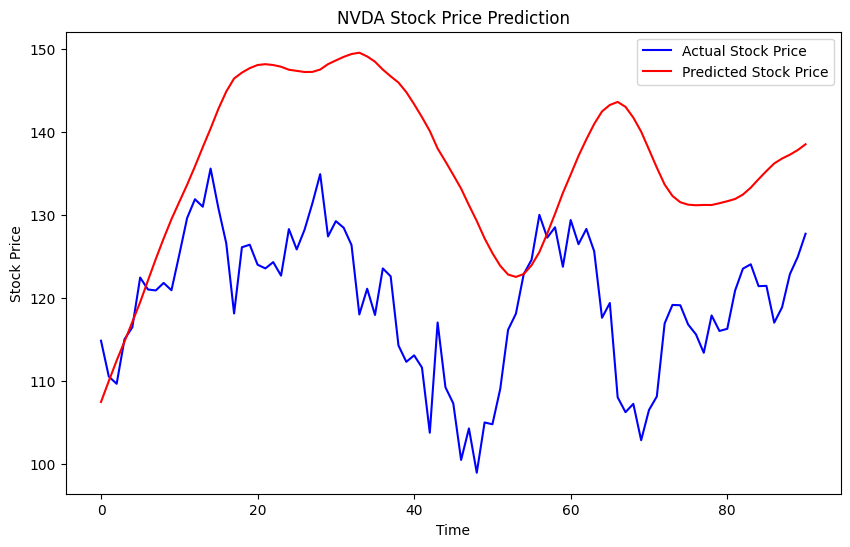

In [79]:
# 예측 수행
predictions = model.predict(x_test)

# 예측 결과를 원래 스케일로 변환
predictions = scaler.inverse_transform(predictions)
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

# 실제 값과 예측 값 시각화
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, color='blue', label='Actual Stock Price')
plt.plot(predictions, color='red', label='Predicted Stock Price')
plt.title(f'{'NVDA'} Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [81]:
from sklearn.metrics import mean_squared_error

rmse = np.sqrt(mean_squared_error(y_test_scaled, predictions))
print(f'RMSE: {rmse}')


RMSE: 19.831360371996823
